<a href="https://colab.research.google.com/github/ImanFatasya/Wafer-Defect-Detection-using-Deep-Learning-FYP-/blob/main/Experiment_4_2_MobileNetV2Classifier_%26_GradCam_FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pretrained model mobilenetv2 experiment 4

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Load preprocessed data
train_X = torch.load('/content/drive/MyDrive/Colab Notebooks/train_X.pt')
train_Y = torch.load('/content/drive/MyDrive/Colab Notebooks/train_Y.pt')
test_X = torch.load('/content/drive/MyDrive/Colab Notebooks/test_X.pt')
test_Y = torch.load('/content/drive/MyDrive/Colab Notebooks/test_Y.pt')

Mounted at /content/drive


<ipython-input-1-643d3c691997>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_X = torch.load('/content/drive/MyDrive/Colab Notebooks/train_X.pt')
<ipython-input-1-6

In [ ]:
train_Y.shape

torch.Size([15400, 1, 9])

In [ ]:
# Hyperparameters
NUM_EPOCH = 50        # Number of epochs
BATCH_SIZE = 32        # Batch size
learning_rate = 0.005  # Learning rate

In [ ]:
# DataSet and DataLoader
# Define dataset class
import torch
from torch.utils.data import Dataset, ConcatDataset
class BasicDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

# Combine datasets
dataset_train = BasicDataset(train_X, train_Y)
dataset_test = BasicDataset(test_X, test_Y)
dataset = ConcatDataset([dataset_train, dataset_test])

In [ ]:
# Define CNN Model using a Pretrained Model (e.g., MobileNet-V2)
class MobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2, self).__init__()
        self.base_model = models.mobilenet_v2(pretrained=True)
        self.base_model.classifier[1] = nn.Linear(self.base_model.last_channel, num_classes)

    def forward(self, x):
        return self.base_model(x)

In [ ]:
# Initialize model, loss function, and optimizer
model = MobileNetV2(num_classes=9).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
#Cross-entropy loss is suitable for multi-class classification tasks.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 67.8MB/s]


In [ ]:
# Inspect model architecture
print(model)

MobileNetV2(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size

In [ ]:
# Initialize lists to hold the metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import train_test_split

# Split dataset into train and validation sets
train_idx, val_idx = train_test_split(range(len(dataset_train)), test_size=0.2, random_state=42)

# Create samplers for training and validation
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

# Create DataLoaders
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, sampler=val_sampler)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
for epoch in range(NUM_EPOCH):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).squeeze()

        # Convert one-hot encoded labels to class indices
        if labels.dim() > 1:
            labels = torch.argmax(labels, dim=1)

        optimizer.zero_grad()
        output = model(images)

        # Calculate the loss
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # Update total loss
        total_loss += loss.item()
        # Calculate predictions
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for training
    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE).squeeze()

            # Convert one-hot encoded labels to class indices for validation
            if labels.dim() > 1:
                labels = torch.argmax(labels, dim=1)

            output = model(images)
            loss = criterion(output, labels)

            val_loss += loss.item()
            _, val_predicted = torch.max(output.data, 1)
            val_total += labels.size(0)
            val_correct += (val_predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    # Print results
    print(f'Epoch: {epoch + 1}/{NUM_EPOCH} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    # Append metrics to lists for plotting
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

# Save model parameters
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/fixed_validation_MobileNetV2&Gradcamexperiment4v2.pt')


Epoch: 1/50 - Train Loss: 1.1356, Train Acc: 61.79%, Val Loss: 0.7672, Val Acc: 70.13%
Epoch: 2/50 - Train Loss: 1.2215, Train Acc: 58.21%, Val Loss: 3.7406, Val Acc: 45.52%
Epoch: 3/50 - Train Loss: 1.1180, Train Acc: 61.31%, Val Loss: 0.7206, Val Acc: 68.80%
Epoch: 4/50 - Train Loss: 0.6965, Train Acc: 72.28%, Val Loss: 0.6975, Val Acc: 74.32%
Epoch: 5/50 - Train Loss: 0.5357, Train Acc: 79.07%, Val Loss: 0.6749, Val Acc: 73.57%
Epoch: 6/50 - Train Loss: 0.5203, Train Acc: 80.27%, Val Loss: 0.4294, Val Acc: 83.83%
Epoch: 7/50 - Train Loss: 0.4718, Train Acc: 82.48%, Val Loss: 0.3688, Val Acc: 85.49%
Epoch: 8/50 - Train Loss: 0.4197, Train Acc: 84.84%, Val Loss: 0.3633, Val Acc: 86.46%
Epoch: 9/50 - Train Loss: 0.3616, Train Acc: 86.62%, Val Loss: 0.4848, Val Acc: 79.81%
Epoch: 10/50 - Train Loss: 0.3775, Train Acc: 86.70%, Val Loss: 0.3221, Val Acc: 87.44%
Epoch: 11/50 - Train Loss: 0.3403, Train Acc: 87.61%, Val Loss: 0.3717, Val Acc: 86.95%
Epoch: 12/50 - Train Loss: 0.3842, Train 

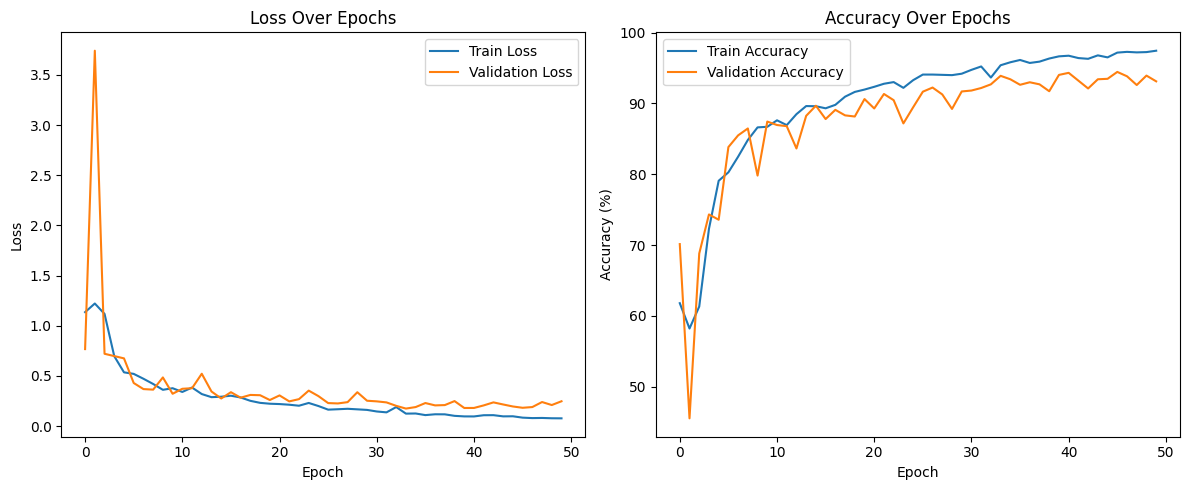

In [ ]:
import matplotlib.pyplot as plt

# After the training loop, plot the metrics
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

TEST

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on the Test Set
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_labels = []
all_predictions = []

test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).squeeze()

        # Convert one-hot encoded labels to class indices for testing
        if labels.dim() > 1:
            labels = torch.argmax(labels, dim=1)

        output = model(images)
        loss = criterion(output, labels)

        test_loss += loss.item()
        _, test_predicted = torch.max(output.data, 1)
        test_total += labels.size(0)
        test_correct += (test_predicted == labels).sum().item()

        # Store labels and predictions for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(test_predicted.cpu().numpy())

# Calculate average test loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * test_correct / test_total

# Print Test Results
print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.2478, Test Accuracy: 92.86%



Confusion Matrix:
[[434   0   1   0   6   0   1   0   2]
 [  0 407   0   0   0   0   0   0   0]
 [  2   0 330  10  28   1  11   3   6]
 [  0   0  27 418   0   0   0   1   0]
 [  6   0  32   0 365   1  10  38  11]
 [  0   0   0   0   0 374  38   0   0]
 [  0   0   1   0   0   0 414   0   0]
 [  1   0   3   0   8   0   0 424   6]
 [  2   0   6   1   6   0   1   5 410]]


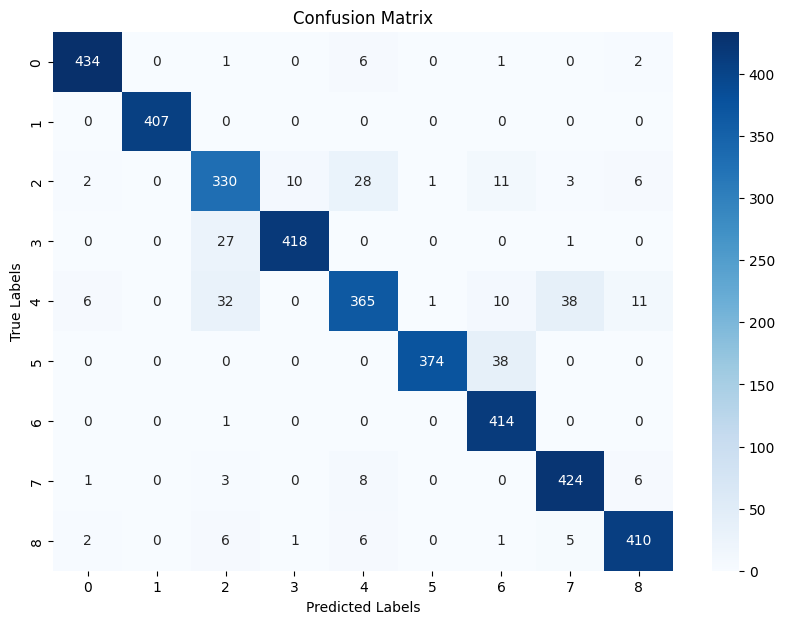


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98       444
     Class 1       1.00      1.00      1.00       407
     Class 2       0.82      0.84      0.83       391
     Class 3       0.97      0.94      0.96       446
     Class 4       0.88      0.79      0.83       463
     Class 5       0.99      0.91      0.95       412
     Class 6       0.87      1.00      0.93       415
     Class 7       0.90      0.96      0.93       442
     Class 8       0.94      0.95      0.95       431

    accuracy                           0.93      3851
   macro avg       0.93      0.93      0.93      3851
weighted avg       0.93      0.93      0.93      3851



In [ ]:
# Generate Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
print("\nConfusion Matrix:")
print(cm)

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(9), yticklabels=range(9))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(9)]))

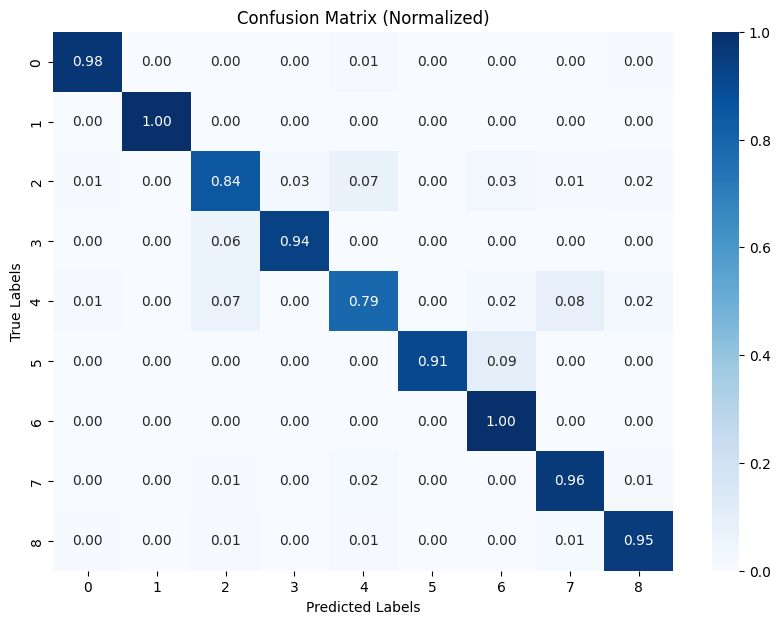


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98       444
     Class 1       1.00      1.00      1.00       407
     Class 2       0.82      0.84      0.83       391
     Class 3       0.97      0.94      0.96       446
     Class 4       0.88      0.79      0.83       463
     Class 5       0.99      0.91      0.95       412
     Class 6       0.87      1.00      0.93       415
     Class 7       0.90      0.96      0.93       442
     Class 8       0.94      0.95      0.95       431

    accuracy                           0.93      3851
   macro avg       0.93      0.93      0.93      3851
weighted avg       0.93      0.93      0.93      3851



In [ ]:
# Plot Confusion Matrix as Heatmap (Normalized values)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(9), yticklabels=range(9))
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(9)]))

# GRAD CAM FUNCTION

In [ ]:
!pip install torchcam
!pip install grad-cam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=0321be8de9d31c4f5470b0f1f4885722a2c1b7ec1eda70fe37590b1a58b68c6e
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-16-97b476e5306f>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for mo

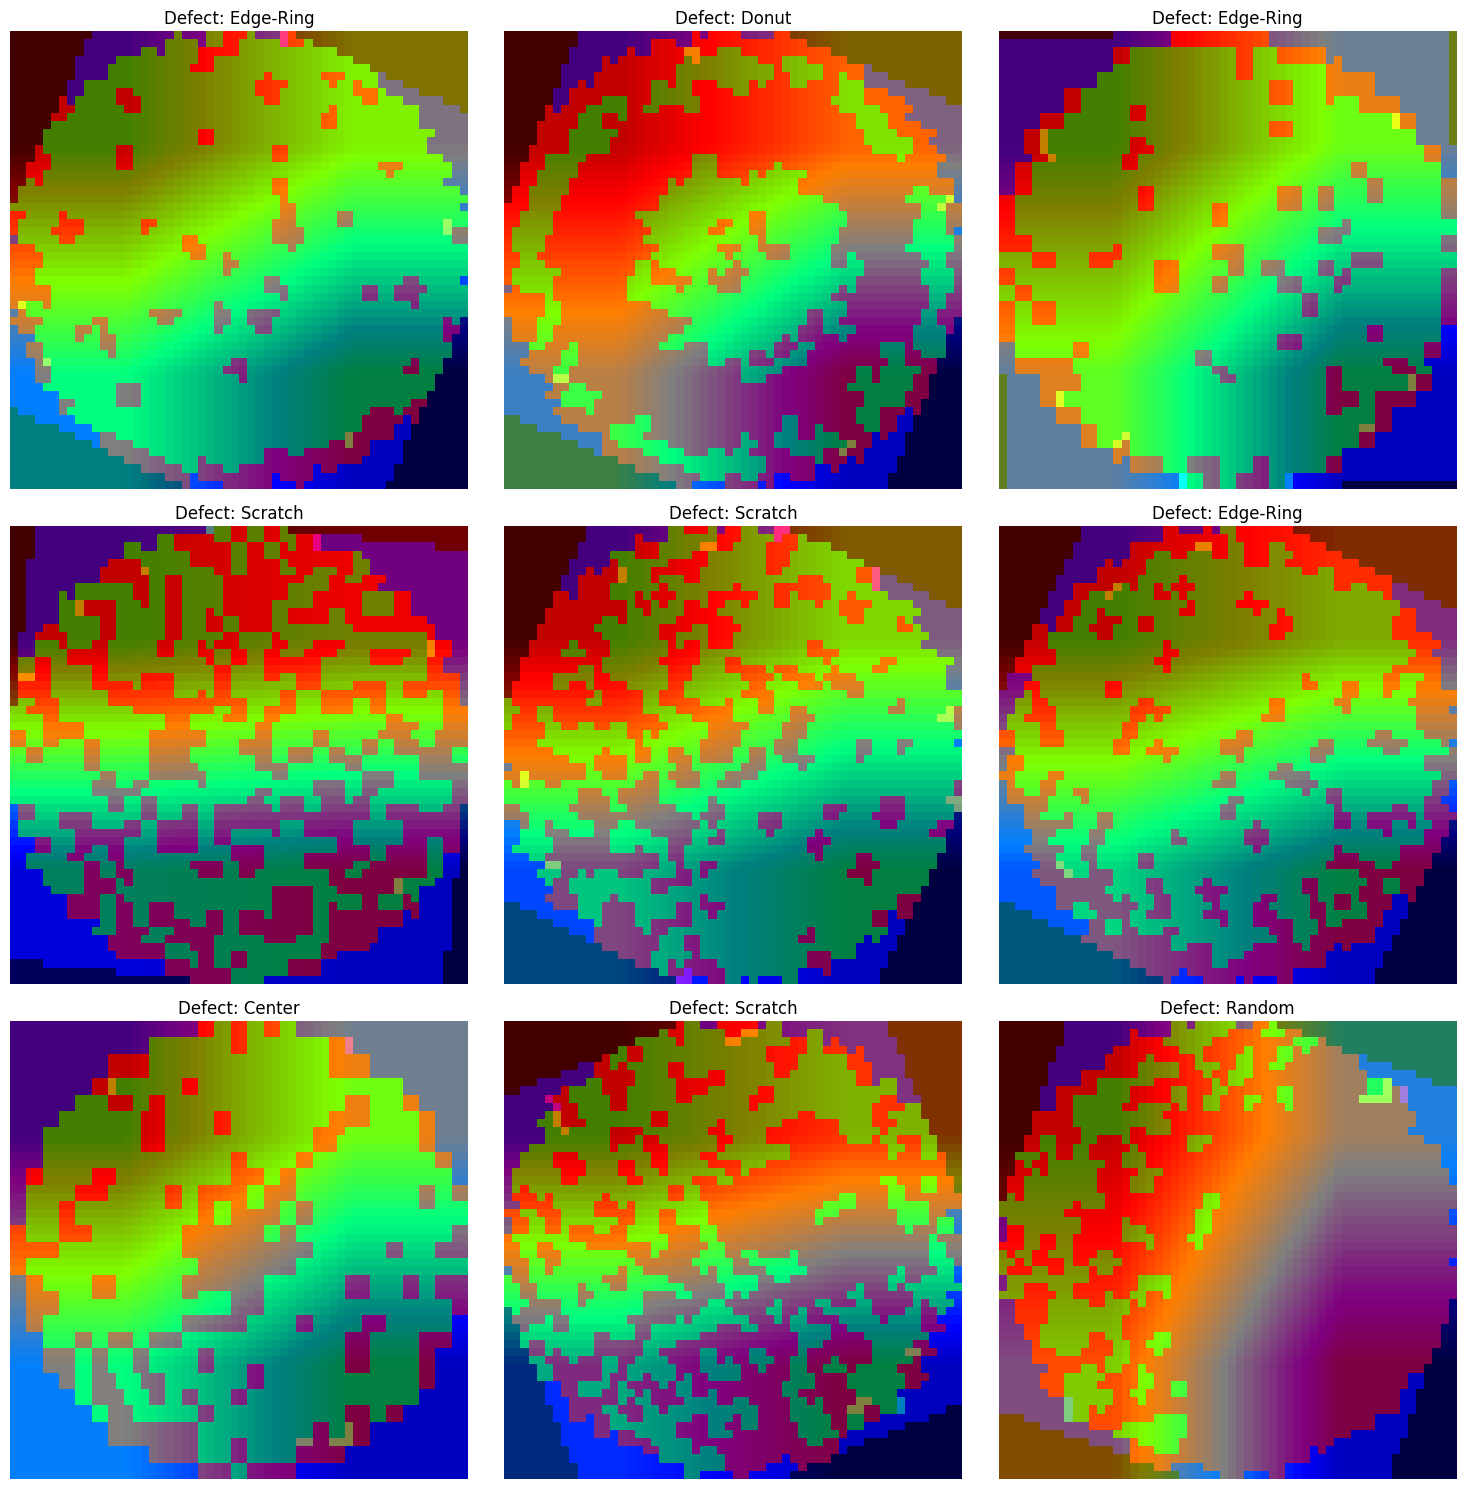

In [ ]:
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import numpy as np
import torch
import torch.nn as nn

# Assuming model is already defined and weights loaded
from torchvision.models import mobilenet_v2
num_classes = 9
model = mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/fixed_validation_MobileNetV2&Gradcamexperiment4v2.pt'), strict=False)  # Note the 'strict=False' argument
model.eval()

# Grad-CAM Initialization
target_layer = model.features[-1]  # Last convolutional layer
cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

defect_labels = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full', 'None']

def plot_wafers_with_cam(data, labels, model, cam, defect_labels, cmap='magma', cols=3):
    """
    Plots Grad-CAM heatmaps superimposed on wafer maps for each defect type.

    Args:
    - data: Tensor of input images, shape (N, C, H, W)
    - labels: List or array of true labels corresponding to the data
    - model: Trained PyTorch model
    - cam: GradCAMPlusPlus instance
    - defect_labels: List of defect labels to map to the classes
    - cmap: Colormap for superimposed heatmap
    - cols: Number of columns in the grid
    """
    rows = int(np.ceil(len(data) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    axes = axes.flatten()

    for idx, ax in enumerate(axes):
        if idx < len(data):
            # Generate Grad-CAM heatmap
            input_tensor = data[idx].unsqueeze(0)  # Add batch dimension
            grayscale_cam = cam(input_tensor=input_tensor, targets=None)

            # Prepare input image for visualization
            input_image = data[idx].permute(1, 2, 0).cpu().numpy()  # Convert to HWC
            input_image = input_image - input_image.min()  # Normalize
            input_image = input_image / input_image.max()
            input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

            # Overlay heatmap
            heatmap = show_cam_on_image(input_image, grayscale_cam[0], use_rgb=True)

            # Get the corresponding defect label
            # Extract the index of the maximum value in the one-hot encoded label
            label_index = torch.argmax(labels[idx]).item()  # Get the index of the defect label
            defect_type = defect_labels[label_index]  # Map label index to defect name

            # Plot the result
            ax.imshow(heatmap, cmap=cmap)
            ax.set_title(f"Defect: {defect_type}")
            ax.axis('off')
        else:
            ax.axis('off')  # Hide extra axes

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `test_X` is a tensor dataset (N, C, H, W) and `test_Y` are the corresponding labels
example_data = test_X[:9]  # Select 9 samples
example_labels = test_Y[:9]  # Corresponding true labels
plot_wafers_with_cam(example_data, example_labels, model, cam, defect_labels)